In [10]:
# Import packages
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics

# Load data
df = pd.read_parquet('data_exjobb_070425.parquet')
df.head()

,TransactionId,SalePrice,Lat,Lon,BuildingAge,UtilityArea,LotArea,QualityScore,CloseToBeach,EnergyPerformance,...,MunicipalityMoveInFromCountyFrac,MunicipalityMoveOutToCountyFrac,MunicipalityMoveInFrac2yrChangeMean,MunicipalityMoveOutFrac2yrChangeMean,MunicipalityMoveInFromCountyFrac2yrChangeMean,MunicipalityMoveOutToCountyFrac2yrChangeMean,MunicipalityPopulationMeanDeviation,MedianRentMunicipality,MedianRentMunicipality2yrFracChangeMean,MedianRentMunicipalityMeanDeviation
0,10006194,3200000,56.742153,16.291778,48,143,480,36,0,60.0,...,0.025551,0.021314,0.001816,0.004082,0.000930,0.003437,4.373830,1155.0,0.091030,1.123790
1,10006232,1700000,57.278909,13.646019,54,120,750,32,0,114.0,...,0.010123,0.013869,-0.007777,0.006713,-0.001110,0.002518,1.843030,999.0,0.013451,0.972005
2,10006302,3500000,58.328009,15.103299,47,169,592,30,0,NaN,...,0.034871,0.028112,-0.003267,0.003278,-0.000932,0.000765,1.738860,1046.0,0.075010,1.017735
3,10006371,11200000,57.739437,14.122176,128,250,3311,30,0,88.0,...,0.013410,0.012764,-0.001062,0.001830,0.000457,0.000039,8.857676,1059.0,0.061507,1.030384
4,10006399,591000,57.784585,16.146614,112,87,3406,28,0,101.0,...,0.006766,0.006466,-0.001024,-0.000181,0.000441,0.000045,2.279611,909.0,0.009151,0.884437


In [11]:
# Create functions

def remove_non_numbers(data):
    del_data = data.copy()

    # Removing all non int or float type features looping from the end.
    iterate = len(del_data[0,:])-1
    for i in range(iterate+1):
        if type(del_data[0,iterate-i]) != float and type(del_data[0,iterate-i]) != int:
            # print(iterate-i, type(del_data[0,iterate-i]), data[0,iterate-i])
            del_data = np.delete(del_data, obj=iterate-i, axis=1)
    """
    for i in range(len(del_data[0,:])):
        print(i, type(del_data[0,i]), del_data[0,i])

    for i in range(len(data[0,:])):
    print(i, type(data[0,i]), data[0,i])
        """
    return del_data


def normalize_feature(feature):
    """Min-max normalization."""
    # This retains the relative position of the data points.
    return (feature-np.min(feature)) / (np.max(feature)-np.min(feature))

def normalize(data, axis=1):
    """Using the normalize_feature function on an np.array along a chosen axis."""
    norm_data = np.zeros_like(data)
    for i in range(data.shape[axis]):
        norm_data[:,i] = normalize_feature(data[:,i])
    return norm_data

def clustering(data, cluster_size=10, distance_type='euclidean'):
    """Takes data, minimum cluster size, distance metric and returns an array of the data with an added column at index 0 with the cluster label and the number of clusters."""
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size, metric=distance_type)
    clusterer.fit(data)
    return clusterer.labels_.max()+1 , np.insert(data, 0, clusterer.labels_.flatten(), axis=1)

def center_of_mass(number_of_clusters, clusters):
    cluster_centers = np.zeros((number_of_clusters, len(clusters[0])))
    balancing_vector = np.zeros_like(cluster_centers)
    clusters[:,0] += 1
    for i in range(len(clusters[:,None])):
        if clusters[i,0] > 0:
            cluster_centers[int(clusters[i,0])-1] += clusters[i]
            balancing_vector[int(clusters[i,0])-1] += 1 # Keeps track of how many points are in each cluster.
    return cluster_centers / balancing_vector




def reduce_dimension(vector,clusters):
    """Takes a vector and a set of clusters and reduces the vectors dimension to the number of clusters using the clusters as a basis."""
    # Vector projection
    transformation_matrix = np.zeros([len(clusters), len(vector)])

    for i in clusters:
        transformation_matrix[i] = center_of_mass(clusters[i])

    reduced_vector = transformation_matrix * vector
    return reduced_vector

# Outline
1. Find Clusters using hdbscan.
2. Find the centers of the clusters.
3. Reduce the dimensionality to the number of clusters and create a new vector space.
4. Find a suitable model for finding comparisons.

# Change to np.array and choose features

Start with excluding the feature that are not int or float.
Later give the unused features numerical values and implement them as well.


In [28]:
# Chaning to numpy array
df = df.fillna(0)
data = df.to_numpy()

data = remove_non_numbers(data)

data = data.astype(float) # Changing from type object to float so that numpy functions work properly.

# Divide the data set into training and testing data
percent = 0.10  # Fraction used for testing
samples = int(len(data[:,None]) * percent)

training_data, testing_data = train_test_split(data, test_size=samples)

print('X1 shape: ', training_data.shape)
print('X2 shape: ', testing_data.shape)


data_points = 100
play_data = training_data[0:data_points, 1:4] # Only using a part of the data.

data = play_data


X1 shape:  (82467, 160)
X2 shape:  (9163, 160)


# Clustering

In [29]:
# Normalizing the data
norm_data = normalize(data)

# Clustering
number_of_clusters, clustered_data = clustering(norm_data)

sorted_clusters = clustered_data[clustered_data[:, 0].argsort()] # sorting the clustered data by cluster affiliation

/opt/anaconda3/envs/Machine_Learning/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/Machine_Learning/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Finding center-of-mass

[0.52202811 0.29404346 0.60803388 0.5077887  0.58087817 0.3362234
 0.65552652 0.51939315 0.44203469 0.22095899] [0.13488833 0.09325498 0.22961989 0.22877748 0.17054454 0.36937769
 0.1582949  0.30207522 0.34668313 0.39239706] [0.04416404 0.24605678 0.13249211 0.12302839 0.22712934 0.11041009
 0.07570978 0.17981073 0.19873817 0.17350158]
[[1.         0.52202811 0.13488833 0.04416404]
 [1.         0.29404346 0.09325498 0.24605678]
 [1.         0.60803388 0.22961989 0.13249211]
 [1.         0.5077887  0.22877748 0.12302839]
 [1.         0.58087817 0.17054454 0.22712934]
 [1.         0.3362234  0.36937769 0.11041009]
 [1.         0.65552652 0.1582949  0.07570978]
 [1.         0.51939315 0.30207522 0.17981073]
 [1.         0.44203469 0.34668313 0.19873817]
 [1.         0.22095899 0.39239706 0.17350158]]
0.4180088769041316 0.2458878268663148 0.14910620399579388


Text(0.5, 0, 'z')

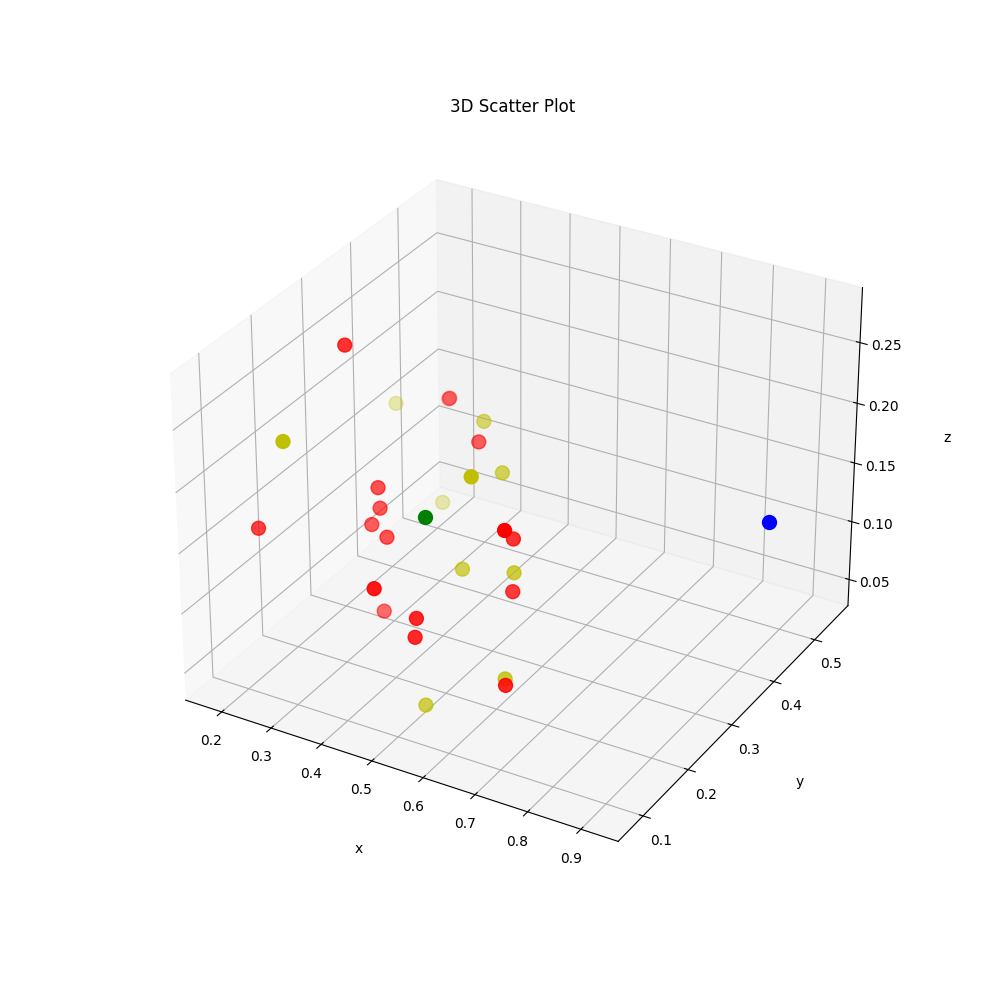

In [30]:
centers_of_mass = center_of_mass(number_of_clusters, clustered_data.copy())

# Test center of mass

%matplotlib widget
x1 = sorted_clusters[73:90, 1]
y1 = sorted_clusters[73:90, 2]
z1 = sorted_clusters[73:90, 3]

x2 = sorted_clusters[90:100, 1]
y2 = sorted_clusters[90:100, 2]
z2 = sorted_clusters[90:100, 3]

print(x2, y2, z2)

print(sorted_clusters[90:100,:])

xc1,yc1,zc1 = centers_of_mass[0, 1:4]
xc2,yc2,zc2 = centers_of_mass[1, 1:4]

print(xc2, yc2, zc2)

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x1, y1, z1, c = 'r', s = 100)
ax.scatter(x2, y2, z2, c = 'y', s = 100)
ax.scatter(xc1,yc1,zc1, c = 'b', s = 100)
ax.scatter(xc2,yc2,zc2, c = 'g', s = 100)
ax.set_title('3D Scatter Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

In [31]:
def vector_norm(vector):
    return np.sqrt(vector @ vector.T)

def create_unit_vector(vector):
    """Takes a vector and creates a unit vector in the same direction."""
    unit_vector = vector / vector_norm(vector)
    return unit_vector

def create_basis(centers_of_mass):
    """Takes the centers_of_mass array and outputs a transformation matrix."""
    basis = np.zeros_like(centers_of_mass[:, 1:])
    for i in range(len(centers_of_mass[:, None])):
        basis[i] = create_unit_vector(centers_of_mass[i, 1:])

    return basis

transformation_matrix = create_basis(centers_of_mass)

"""
print(np.shape(transformation_matrix@norm_data.T))
print(centers_of_mass)
print(transformation_matrix)
print(transformation_matrix[1,:]@transformation_matrix[1,:].T)
print(transformation_matrix@norm_data.T)
"""

embedded_data = (transformation_matrix@norm_data.T).T

norm_embedded_data = normalize(embedded_data)

# print(embedded_data)
# print(np.shape(embedded_data))
print(norm_embedded_data)

[[0.28516051 0.29337421]
 [0.80313476 0.78727186]
 [0.55312996 0.57008127]
 [0.08600205 0.10596589]
 [0.97684699 0.96247029]
 [0.52125931 0.49204168]
 [0.84738689 0.82705696]
 [0.2853753  0.27094986]
 [0.42322804 0.41880887]
 [0.51576661 0.51649593]
 [0.39728317 0.36096293]
 [0.17330349 0.21323165]
 [0.54768154 0.50075338]
 [0.351109   0.32134839]
 [0.27606553 0.24702409]
 [0.12797878 0.10994039]
 [0.26808193 0.25153328]
 [0.85544472 0.83451618]
 [0.8763169  0.86960414]
 [0.55863983 0.53547754]
 [0.94887496 0.92385077]
 [0.42607184 0.45537107]
 [0.84789049 0.82513173]
 [0.08628785 0.05100728]
 [0.82745814 0.80464913]
 [0.94234961 0.96385802]
 [0.95437314 0.94123504]
 [0.42119436 0.42090492]
 [0.         0.        ]
 [1.         1.        ]
 [0.71494014 0.73669672]
 [0.98419496 0.97243963]
 [0.05574723 0.05672968]
 [0.32730622 0.33292242]
 [0.84865466 0.81737484]
 [0.2870962  0.27544865]
 [0.84987805 0.81451131]
 [0.95124909 0.93549155]
 [0.54240581 0.49819613]
 [0.08735593 0.06981393]


In [32]:

def linear_training(data, targets, learning_rate):
    
    weights = np.random.random((np.shape(data[0,:])))
    bias = 0

    for i in range(len(data[:,None])):
        output = weights @ data[i,:] + bias
        residual_error = targets[i] - output
        weights += learning_rate * residual_error

    return weights


learning_rate = 0.01
targets = data[:,4]    # Need to check which index it should be.
trained_data = linear_training(training_data, targets, learning_rate)


IndexError: index 4 is out of bounds for axis 1 with size 3

In [34]:
reg = linear_model.LinearRegression()
reg.fit(training_data)

TypeError: LinearRegression.fit() missing 1 required positional argument: 'y'

In [ ]:
class LinearRegression:
    def __init__(self, learning_rate, iterations):
        self.lr = learning_rate
        self.iterations = iterations

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weight = np.random.random((np.shape(data[0,:])))
        self.bias = 0

        for _ in range(self.iterations):
            y_predict = np.dot(X, self.weight) + self.bias
            dw = 1/n_samples * np.dot(X.T, y_predict-y)
            db = 1/n_samples * np.sum(y_predict - y)

            self.weight -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_predict = np.dot(X, self.weight) + self.bias
        return y_predict
    
    def mse(self, y_true, y_pred):
        error = np.mean((y_true-y_pred)**2)
        return error
    

    

# Model
Use scikit-learn?

Blir clustringen densamma om datan inte är normaliserad?

In [ ]:
# Linear regression

# Boosted tree

# Neural network